# Motody i narzędzia z etapu 2 wykorzystywane podczas 3 cześci projektu

## Pobranie danych

In [33]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import statistics
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

def read_data():
    df = pd.read_excel('./NewData.xlsx')
    data = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    data =  shuffle(data, random_state=50)
    #usunięcie nieużywanych kolumn, ze względu na użycie tylko jednej zminnej objasnianej jako "cnt"
    data.drop('casual', inplace=True, axis=1)
    data.drop('registered', inplace=True, axis=1)
    return data
    
data = read_data()
data.head()

,yr,season,mnth,hr,holiday,weekday,weathersit,temp,atemp,hum,windspeed,cnt
6353,0,4,9,7,0,2,2,0.638860,0.405491,1.689607,-0.699826,249
8618,0,1,12,21,0,5,2,-0.711435,-0.652568,0.244387,-0.699826,95
14957,1,3,9,10,0,4,1,0.431122,0.405491,-0.426609,-0.821827,190
2674,0,2,4,8,0,2,1,0.431122,0.405491,1.121842,0.886187,449
13290,1,3,7,23,0,4,2,1.054335,1.022691,-1.407294,0.276182,211


## Podział danych

In [34]:
def train_test_split(X, Y, test_size):
    train_pct_index = int((1 - test_size) * len(X))
    X_train, X_test = X[:train_pct_index], X[train_pct_index:]
    y_train, y_test = Y[:train_pct_index], Y[train_pct_index:]
    return X_train, X_test, y_train, y_test


def splitOfData(dataInput, testSize, random_state = 50):
    m, n = dataInput.shape
    X = (dataInput.iloc[:,:n-1])
    Y = (dataInput.iloc[:,n-1:n])
    return train_test_split(X, Y, test_size=testSize)

x_train, x_test, y_train, y_test = splitOfData(data, 0.20)
print("x_train.shape: ", x_train.shape)
print("x_test.shape: ", x_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape: ", y_test.shape)

x_train.shape:  (13903, 11)
x_test.shape:  (3476, 11)
y_train.shape:  (13903, 1)
y_test.shape:  (3476, 1)


## Miary Skuteczności

In [3]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

def calculate_MSE(Y, predykcja):
    Y = Y.to_numpy()
    m = len(Y)
    suma = 0
    for i in range(m):
        suma += (predykcja[i] - Y[i])**2
    return (suma / m)[0]

def calculate_r2(Y, predykcja):
    Y = Y.to_numpy()
    g = 0
    y = 0
    m = np.mean(Y)
    for i in range(len(Y)):
        x = (Y[i] - predykcja[i]) **2
        g = g + x
        y = y + ((Y[i] - m) ** 2)
    return (1 - (g / y))[0]

def calculate_exp_var_score(y_true, y_pred):
    y_true = y_true.to_numpy()
    diffr = []
    for i in range(len(y_true)):
        diffr.append(y_true[i] - y_pred[i]) 
    x = np.var(diffr) / np.var(y_true)
    return 1 - x
    
def statistics(y_pred, y_test, show_print=False, show_only_custom=False):
    custom_MSE = round(calculate_MSE(y_test, y_pred),5)
    custom_r2 = round(calculate_r2(y_test, y_pred),5)
    custom_evs = round(calculate_exp_var_score(y_test, y_pred),5)
    if (show_print):
        if(not show_only_custom):
            mse = round(mean_squared_error(y_test, y_pred),5)
            r2 = round(r2_score(y_test, y_pred),5)
            EVS = round(explained_variance_score(y_test, y_pred),5)
            print("RMSE of test set is {}".format(mse))
            print("R2 score of test set is {}".format(r2))
            print("EVS score of test set is {}".format(EVS))
            print("\n")
        print("Custom MSE test set is {}".format(custom_MSE))
        print("Custom r2 test set is {}".format(custom_r2))
        print("Custom EVS test set is {}".format(custom_evs))
        if(not show_only_custom):
            plt.scatter(x_test["temp"], y_test, color="black")
            plt.scatter(x_test["temp"], y_pred, color="blue")
            plt.title("zalżeność liczby wypożyczeń od temperatury [rzeczywista-czarna, predyktowana-niebieska]")
            plt.xlabel("temperatura")
            plt.ylabel("cnt")
            plt.show()
    return custom_MSE, custom_r2, custom_evs

## Regresja Liniowa

In [9]:
from sklearn import linear_model

def linear_regression(x_train, x_test, y_train, print_coefficiens=False):
    linear_reg = linear_model.LinearRegression()
    linear_reg.fit(x_train, y_train)
    linear_reg_pred = linear_reg.predict(x_test)
    if (print_coefficiens):
        linear_reg_coefficients = linear_reg.coef_[0]
        print("coefficients:\n", linear_reg_coefficients)
        index = ['yr', 'season', 'mnth', 'hr', 'holiday', 'weekday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
        coefficients_frame = pd.DataFrame({'parametr': index, 'Coefficients': linear_reg_coefficients})
        coefficients_frame.plot.bar(x='parametr', y='Coefficients', rot=90)
        plt.show()
    return linear_reg_pred

linear = linear_regression(x_train, x_test, y_train)
a,b,c = statistics(linear, y_test, True, True)

Custom MSE test set is 20177.21457
Custom r2 test set is 0.38581
Custom EVS test set is 0.38618


## Regresja wielomianowa

In [10]:
from sklearn.preprocessing import PolynomialFeatures

def polynomial_regression(x_train, x_test, y_train):
    poly_features = PolynomialFeatures(2)
    x_train_poly = poly_features.fit_transform(x_train)
    poly_model = linear_model.LinearRegression()
    poly_model.fit(x_train_poly, y_train)
    poly_reg_pred = poly_model.predict(poly_features.fit_transform(x_test))
    return poly_reg_pred

polynomial = polynomial_regression(x_train, x_test, y_train)
a, b, c = statistics(polynomial, y_test, True, True)

Custom MSE test set is 15331.44125
Custom r2 test set is 0.53332
Custom EVS test set is 0.53344


## Decision Tree Regression

In [11]:
from sklearn.tree import DecisionTreeRegressor

def decision_tree_regression(x_train, x_test, y_train):
    dc_model =  DecisionTreeRegressor()  
    dc_model.fit(x_train, y_train)
    dc_reg_pred = dc_model.predict(x_test)
    return dc_reg_pred

decision_tree = decision_tree_regression(x_train, x_test, y_train)
a, b, c = statistics(decision_tree, y_test, True, True)

Custom MSE test set is 3358.48741
Custom r2 test set is 0.89777
Custom EVS test set is 0.89779


## Random Forrest Regression

In [12]:
from sklearn.ensemble import RandomForestRegressor

def random_forrest_regression(x_train, x_test, y_train):
    rf_model =  RandomForestRegressor()
    rf_model.fit(x_train, y_train)
    rf_reg_pred = rf_model.predict(x_test)
    return rf_reg_pred

random_forrest = random_forrest_regression(x_train, x_test, y_train)
a, b, c = statistics(random_forrest, y_test, True, True)

Custom MSE test set is 1980.50502
Custom r2 test set is 0.93971
Custom EVS test set is 0.93972


## Voting Regressor

In [13]:
from sklearn.ensemble import VotingRegressor

def voting_regression(x_train, x_test, y_train):
    lr_model = linear_model.LinearRegression()
    dc_model = DecisionTreeRegressor()  
    rf_model = RandomForestRegressor()
    voting_model =  VotingRegressor([('lr', lr_model), ('dc', dc_model), ('rf', rf_model)],
                                    weights=[1, 4,5],n_jobs=-1)
    voting_model.fit(x_train, y_train)
    voiting_reg_pred = voting_model.predict(x_test)
    return voiting_reg_pred

voting_regressor = voting_regression(x_train, x_test, y_train)
a, b, c = statistics(voting_regressor, y_test, True, True)

Custom MSE test set is 2318.62262
Custom r2 test set is 0.92942
Custom EVS test set is 0.92942


## Stacking Regressor

In [14]:
from sklearn.ensemble import StackingRegressor

def stacking_regression(x_train, x_test, y_train):
    lr_model = linear_model.LinearRegression()
    dc_model = DecisionTreeRegressor()  
    rf_model = RandomForestRegressor()
    estimators = [('lr', lr_model), ('dc', dc_model), ('rf', rf_model)]
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=rf_model)
    stacking_model.fit(x_train, y_train)
    stacking_reg_pred = stacking_model.predict(x_test)
    return stacking_reg_pred

stacking_regressor = stacking_regression(x_train, x_test, y_train)
a, b, c = statistics(stacking_regressor, y_test, True, True)

Custom MSE test set is 2240.35368
Custom r2 test set is 0.9318
Custom EVS test set is 0.93187


## K - krotna walidacja krzyżowa

In [15]:
from random import seed
from random import randrange

def cross_validation_split(data, folds):
    dataset = data.copy().to_numpy()
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

## Porównanie modeli regresji

In [24]:
def prepare_result(grid_search_optimalization=False):
    linear_results = list()
    polynomial_results = list()
    decision_tree_results = list()
    random_forrest_results = list()
    voting_results = list()
    stacking_results = list()

    linear_pred = linear_regression(x_train, x_test, y_train)
    polynomial_pred = polynomial_regression(x_train, x_test, y_train)
    linear_results.append(statistics(linear_pred, y_test))
    polynomial_results.append(statistics(polynomial_pred, y_test))

    if (not grid_search_optimalization):
        decision_tree_pred = decision_tree_regression(x_train, x_test, y_train)
        random_forrest_pred = random_forrest_regression(x_train, x_test, y_train)
        voting_pred = voting_regression(x_train, x_test, y_train)
        stacking_pred = stacking_regression(x_train, x_test, y_train)
    else:
        grid_search_dt_result = grid_search_on_decision_tree(x_train, y_train)
        grid_search_rf_result = grid_search_on_random_forrest(x_train, y_train)
        decision_tree_pred = decision_tree_regression_optimalized(x_train, x_test, y_train, grid_search_dt_result)
        random_forrest_pred = random_forrest_regression_optimalized(x_train, x_test, y_train, grid_search_rf_result)
        voting_pred = voting_regression_optimalized(x_train, x_test, y_train, grid_search_dt_result, grid_search_rf_result)
        stacking_pred = stacking_regression_optimalized(x_train, x_test, y_train, grid_search_dt_result, grid_search_rf_result)

    decision_tree_results.append(statistics(decision_tree_pred, y_test))
    random_forrest_results.append(statistics(random_forrest_pred, y_test))
    voting_results.append(statistics(voting_pred, y_test))
    stacking_results.append(statistics(stacking_pred, y_test))
        
    return linear_results, polynomial_results, decision_tree_results, random_forrest_results, voting_results, stacking_results

In [21]:
# podzial danych na traningowe i testowe w stosunku 1/k (k = 4 -> 25% danych testowych)
def prepare_result_with_k_fold(k, grid_search_optimalization=False):
    seed(1)
    folds = cross_validation_split(data, k)

    linear_results = list()
    polynomial_results = list()
    decision_tree_results = list()
    random_forrest_results = list()
    voting_results = list()
    stacking_results = list()
    grid_search_dt_result = []
    grid_search_rf_result = []
    
    if (grid_search_optimalization):
        grid_search_dt_result = grid_search_on_decision_tree(x_train, y_train)
        grid_search_rf_result = grid_search_on_random_forrest(x_train, y_train)

    for i in range(k):
        train = folds.copy()
        test = pd.DataFrame(folds[i])
        del train[i]
        train = pd.DataFrame([item for sublist in train for item in sublist])
        m, n = data.shape
        X_train = (train.iloc[:,:n-1])
        Y_train = (train.iloc[:,n-1:n])
        X_test = (test.iloc[:,:n-1])
        Y_test = (test.iloc[:,n-1:n])

        linear_pred = linear_regression(X_train, X_test, Y_train)
        polynomial_pred = polynomial_regression(X_train, X_test, Y_train)
        linear_results.append(statistics(linear_pred, Y_test))
        polynomial_results.append(statistics(polynomial_pred, Y_test))
        
        if (not grid_search_optimalization):
            decision_tree_pred = decision_tree_regression(X_train, X_test, Y_train)
            random_forrest_pred = random_forrest_regression(X_train, X_test, Y_train)
            voting_pred = voting_regression(X_train, X_test, Y_train)
            stacking_pred = stacking_regression(X_train, X_test, Y_train)
        else:
            decision_tree_pred = decision_tree_regression_optimalized(X_train, X_test, Y_train, grid_search_dt_result)
            random_forrest_pred = random_forrest_regression_optimalized(X_train, X_test, Y_train, grid_search_rf_result)
            voting_pred = voting_regression_optimalized(X_train, X_test, Y_train, grid_search_dt_result, grid_search_rf_result)
            stacking_pred = stacking_regression_optimalized(X_train, X_test, Y_train, grid_search_dt_result, grid_search_rf_result)

        decision_tree_results.append(statistics(decision_tree_pred, Y_test))
        random_forrest_results.append(statistics(random_forrest_pred, Y_test))
        voting_results.append(statistics(voting_pred, Y_test))
        stacking_results.append(statistics(stacking_pred, Y_test))
        
    return linear_results, polynomial_results, decision_tree_results, random_forrest_results, voting_results, stacking_results

In [20]:
from prettytable import PrettyTable

def add_row(table, result, model):
    avg_result = [sum(x) / len(x) for x in zip(*result)]
    table.add_row([model, round(avg_result[0],5), round(avg_result[1],5), round(avg_result[2],5)])
    
def createSummaryTable(summary_table, results):
    add_row(summary_table, results[0], "Linear Regression")
    add_row(summary_table, results[1], "Polynominal Regression")
    add_row(summary_table, results[2], "Decision Tree Regression")
    add_row(summary_table, results[3], "Random Forrest Regression")
    add_row(summary_table, results[4], "Voting Regressor")
    add_row(summary_table, results[5], "Stacking Regressor")  

def createSummary(k_fold = 0, grid_search_optimalization = False):
    summary_table = PrettyTable(['model', 'MSE', 'r2', 'Experience Variance'])
    if (k_fold < 2):
        results = prepare_result(grid_search_optimalization)
        createSummaryTable(summary_table, results)
        print("Summary table for result of regression models:\n", summary_table, "\n\n")
    else:
        results = prepare_result_with_k_fold(k_fold, grid_search_optimalization)
        createSummaryTable(summary_table, results)
        print("Summary table for result of regression models [K_fold: k =",k_fold,"]:\n", summary_table, "\n\n")

# Etap 3

## Optymalizacja Cech

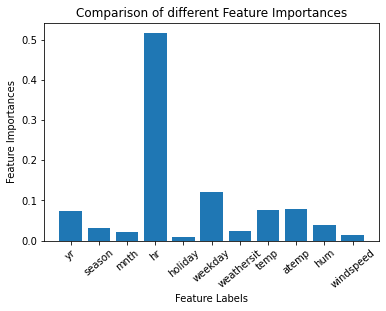

In [42]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from random import seed
from random import randrange

extra_tree = ExtraTreeRegressor(random_state=0)
extra_tree_model = ExtraTreesRegressor(n_estimators = 100,
          criterion ='mse', max_features = "auto")
extra_tree_model.fit(x_train, y_train)

feature_importance = extra_tree_model.feature_importances_
plt.bar(x_train.columns, feature_importance)
plt.xticks(rotation=40)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

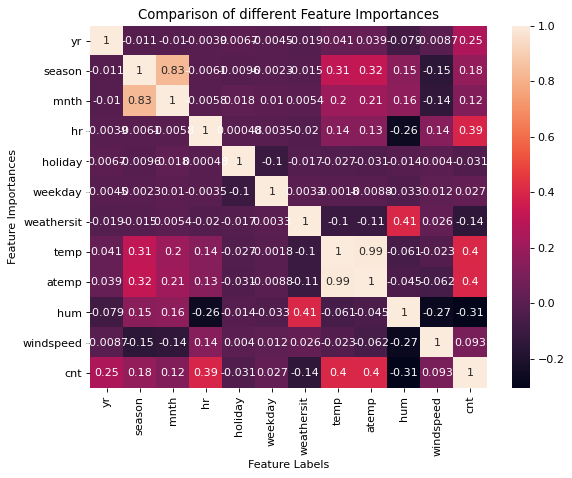

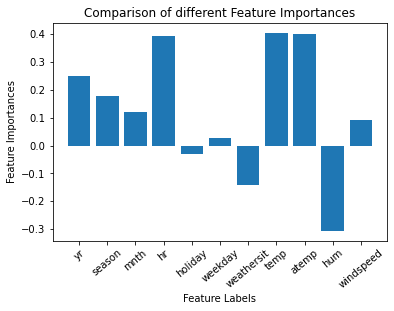

In [41]:
import seaborn as sns
figure(figsize=(8, 6), dpi=80)

corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

plt.bar(data.columns[:11], corrMatrix["cnt"][:11])
plt.xticks(rotation=40)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

Na podstawie wyników z Extra Tree regressora zrezygnowaliśmy z 6 parametrów jaki są:
- season
- month
- holiday
- weathersit
- hum
- windspeed

Dodatkowo na podstawie macierzy korelacji zdecydowaliśmy się odrzucić jedną z cech opisujących temperaturę, a więc:
- temp

In [18]:
data = read_data()

size_before_opt = np.shape(data)[1] - 1
print("Ilosc wymairów zmiennych zależnych przed optymalizacją: ", size_before_opt)
data.drop('season', inplace=True, axis=1)
data.drop('mnth', inplace=True, axis=1)
data.drop('holiday', inplace=True, axis=1)
data.drop('weathersit', inplace=True, axis=1)
data.drop('temp', inplace=True, axis=1)
data.drop('hum', inplace=True, axis=1)
data.drop('windspeed', inplace=True, axis=1)
size_after_opt = np.shape(data)[1] - 1
print("Ilosc wymairów zmiennych zależnych po optymalizacji: ",size_after_opt)

x_train, x_test, y_train, y_test = splitOfData(data, 0.20)

Ilosc wymairów zmiennych zależnych przed optymalizacją:  11
Ilosc wymairów zmiennych zależnych po optymalizacji:  4


In [251]:
createSummary()    
createSummary(k_fold = 2)    
createSummary(k_fold = 5)
createSummary(k_fold = 10)

Summary table for result of regression models:
 +---------------------------+--------------------+--------------------+---------------------+
|           model           |        MSE         |         r2         | Experience Variance |
+---------------------------+--------------------+--------------------+---------------------+
|     Linear Regression     | 21867.761326676096 | 0.3343528459785504 |  0.3347091750508546 |
|   Polynominal Regression  | 16882.76129072206  | 0.4860945371905242 |  0.4862972295217204 |
|  Decision Tree Regression | 6548.333144683483  | 0.8006709851901681 |  0.8007192480173333 |
| Random Forrest Regression | 4938.322646535097  | 0.849679152511337  |  0.849759701971445  |
|      Voting Regressor     | 5330.180580392806  | 0.8377511314141377 |  0.8378398952641618 |
|     Stacking Regressor    | 5085.8598129064085 | 0.8451881717730549 |  0.8453532576464577 |
+---------------------------+--------------------+--------------------+---------------------+ 


Summary t

Ostatecznie modele posiadają 4 zmienne niezależne którymi śa parametry:
- weekday
- hr
- year
- atemp

W rezultacie dla używanych modeli regresji skuteczność r2 spadło od ok. 5% do 9%.\
Uznaliśmy że w ramach optymalizacji jest to dopuszczalny spadek przy takiej ilości wyeliminowanych cech.

## Optymalizacja hiper parametrów

W ramach tej optymalizacji zostały pominięte modele regresji liniowej i logistycznej.

In [40]:
from sklearn.model_selection import GridSearchCV
def grid_search_on_random_forrest(x_train, y_train, print_result=False):
    param_grid = dict(
        max_depth = [6, 12, 24], 
        random_state = [5, 50, 75], 
        n_estimators = [100, 150, 200, 250])
    grid = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, verbose=0, n_jobs=-1, refit=True)
    grid_results = grid.fit(x_train, y_train)
    if(print_result):
        print("Best Random Forrest Regression score: {0}, \nusing {1}\n\n".format(grid_results.best_score_, grid_results.best_params_))
    return grid_results

def random_forrest_regression_optimalized(x_train, x_test, y_train, grid_results):   
    rf_model =  RandomForestRegressor(max_depth = grid_results.best_params_["max_depth"], 
                                      random_state = grid_results.best_params_["random_state"], 
                                      n_estimators = grid_results.best_params_["n_estimators"],
                                      min_samples_split = 2,
                                      min_samples_leaf = 2)
    rf_model.fit(x_train, y_train)
    rf_reg_pred = rf_model.predict(x_test)
    return rf_reg_pred

grid_search_rf_result = grid_search_on_random_forrest(x_train, y_train, True)
random_forrest_optimalized = random_forrest_regression_optimalized(x_train, x_test, y_train, grid_search_rf_result)
a, b, c = statistics(random_forrest_optimalized, y_test, True, True)

Best Random Forrest Regression score: 0.9333002808704588, 
using {'max_depth': 24, 'n_estimators': 250, 'random_state': 5}


Custom MSE test set is 2069.7662874926646
Custom r2 test set is 0.936997024149959
Custom EVS test set is 0.93699790938967


In [44]:
def grid_search_on_decision_tree(x_train, y_train, print_result=False):
    param_grid = dict(
        max_depth = [None, 6, 12, 24], 
        random_state = [None, 50, 75], 
        splitter = ["best", "random"], 
        min_samples_leaf = [1,2,3],
        min_samples_split = [2,3,4])
    grid = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=param_grid, verbose=0, n_jobs=-1, refit=True)
    grid_results = grid.fit(x_train, y_train)
    if(print_result):
        print("Best Decision Tree Regression score: {0}, \nusing {1}\n\n".format(grid_results.best_score_, grid_results.best_params_))
    return grid_results

def decision_tree_regression_optimalized(x_train, x_test, y_train, grid_results):
    dc_model =  DecisionTreeRegressor(max_depth = grid_results.best_params_["max_depth"], 
                                      random_state = grid_results.best_params_["random_state"], 
                                      splitter = grid_results.best_params_["splitter"], 
                                      min_samples_leaf = grid_results.best_params_["min_samples_leaf"], 
                                      min_samples_split = grid_results.best_params_["min_samples_split"])
    dc_model.fit(x_train, y_train)
    dc_reg_pred = dc_model.predict(x_test)
    return dc_reg_pred

grid_search_dt_result = grid_search_on_decision_tree(x_train, y_train, True)
decision_tree_optimalized = decision_tree_regression_optimalized(x_train, x_test, y_train, grid_search_dt_result)
a, b, c = statistics(decision_tree_optimalized, y_test, True, True)

Best Decision Tree Regression score: 0.8822328865034675, 
using {'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 75, 'splitter': 'best'}


Custom MSE test set is 3335.727975156618
Custom r2 test set is 0.8984615846092994
Custom EVS test set is 0.8984666819534011


In [42]:
def voting_regression_optimalized(x_train, x_test, y_train, grid_search_dt_result, grid_search_rf_result):
    lr_model = linear_model.LinearRegression()
    dc_model =  DecisionTreeRegressor(max_depth = grid_search_dt_result.best_params_["max_depth"], 
                                      splitter = grid_search_dt_result.best_params_["splitter"], 
                                      random_state = grid_search_dt_result.best_params_["random_state"], 
                                      min_samples_leaf = grid_search_dt_result.best_params_["min_samples_leaf"], 
                                      min_samples_split = grid_search_dt_result.best_params_["min_samples_split"]) 
    rf_model =  RandomForestRegressor(max_depth = grid_search_rf_result.best_params_["max_depth"], 
                                      random_state = grid_search_rf_result.best_params_["random_state"], 
                                      n_estimators = grid_search_rf_result.best_params_["n_estimators"],
                                      min_samples_split = 2,
                                      min_samples_leaf = 2)
    voting_model =  VotingRegressor([('lr', lr_model), ('dc', dc_model), ('rf', rf_model)],
                                     weights=[1,4,5],n_jobs=-1)
    voting_model.fit(x_train, y_train)
    voiting_reg_pred = voting_model.predict(x_test)
    return voiting_reg_pred

voting_regressor_opt = voting_regression_optimalized(x_train, x_test, y_train, grid_search_dt_result, grid_search_rf_result)
a, b, c = statistics(voting_regressor_opt, y_test, True, True)

Custom MSE test set is 2501.293552031716
Custom r2 test set is 0.9238614822336186
Custom EVS test set is 0.923866964526679


In [46]:
def stacking_regression_optimalized(x_train, x_test, y_train, grid_search_dt_result, grid_search_rf_result):
    lr_model = linear_model.LinearRegression()
    dc_model =  DecisionTreeRegressor(max_depth = grid_search_dt_result.best_params_["max_depth"], 
                                      splitter = grid_search_dt_result.best_params_["splitter"], 
                                      random_state = grid_search_dt_result.best_params_["random_state"], 
                                      min_samples_leaf = grid_search_dt_result.best_params_["min_samples_leaf"], 
                                      min_samples_split = grid_search_dt_result.best_params_["min_samples_split"]) 
    rf_model =  RandomForestRegressor(max_depth = grid_search_rf_result.best_params_["max_depth"], 
                                      random_state = grid_search_rf_result.best_params_["random_state"], 
                                      n_estimators = grid_search_rf_result.best_params_["n_estimators"],
                                      min_samples_split = 2,
                                      min_samples_leaf = 2)
    estimators = [('lr', lr_model), ('dc', dc_model), ('rf', rf_model)]
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=rf_model)
    stacking_model.fit(x_train, y_train)
    stacking_reg_pred = stacking_model.predict(x_test)
    return stacking_reg_pred

stacking_regressor_opt = stacking_regression_optimalized(x_train, x_test, y_train, grid_search_dt_result, grid_search_rf_result)
a, b, c = statistics(stacking_regressor_opt, y_test, True, True)

Custom MSE test set is 2302.7234793663156
Custom r2 test set is 0.929905887134925
Custom EVS test set is 0.9299226821003312


In [236]:
createSummary(grid_search_optimalization = True)
createSummary(k_fold = 2, grid_search_optimalization = True)
createSummary(k_fold = 3, grid_search_optimalization = True)
createSummary(k_fold = 5, grid_search_optimalization = True)
createSummary(k_fold = 10, grid_search_optimalization = True)

Summary table for result of regression models:
 +---------------------------+--------------------+--------------------+---------------------+
|           model           |        MSE         |         r2         | Experience Variance |
+---------------------------+--------------------+--------------------+---------------------+
|     Linear Regression     | 21867.761326676096 | 0.3343528459785504 |  0.3347091750508546 |
|   Polynominal Regression  | 16882.76129072206  | 0.4860945371905242 |  0.4862972295217204 |
|  Decision Tree Regression | 4572.403653294725  | 0.8608176011533439 |  0.8608542174081296 |
| Random Forrest Regression |  4425.77062718543  | 0.8652810601721754 |  0.8653671637414859 |
|      Voting Regressor     | 4400.150993919807  | 0.8660609130211057 |  0.8661409747711207 |
|     Stacking Regressor    | 4748.354352767109  | 0.8554617222134635 |  0.855696766384507  |
+---------------------------+--------------------+--------------------+---------------------+ 


Summary t

Wyniki optymalizacji hiperparametrów przyniosły pozytywny efekt, w ramach którego skuteczność r2 dla używanaych modeli wzrosła przecietnie o 2-3%, a dla Decision Tree Regressor nawet o 6%

## Porównanie wykonanych operacja dla modelów regresji

In [103]:
def k_fold_alg(data, method, k, out, optimalization=False, grid_search_dt=[], grid_search_rf=[]):
    seed(1)
    folds = cross_validation_split(data, k)
    for i in range(k):
        train = folds.copy()
        test = pd.DataFrame(folds[i])
        del train[i]
        train = pd.DataFrame([item for sublist in train for item in sublist])
        n = np.shape(data)[1]
        X_train = (train.iloc[:,:n-1])
        Y_train = (train.iloc[:,n-1:n])
        X_test = (test.iloc[:,:n-1])
        Y_test = (test.iloc[:,n-1:n])
        calc_regression(method, out, X_train, X_test, Y_train, Y_test, optimalization, grid_search_dt, grid_search_rf)

def calc_regression(method, out, x_train, x_test, y_train, y_test, optimalization=False, grid_search_dt=[], grid_search_rf=[]):
    if(method == "linear"):    
        out.append(statistics(linear_regression(x_train, x_test, y_train), y_test))
    if(method == "polynominal"):    
        out.append(statistics(polynomial_regression(x_train, x_test, y_train), y_test))
    if (not optimalization):
        if(method == "decision_tree"):    
            out.append(statistics(decision_tree_regression(x_train, x_test, y_train), y_test))
        if(method == "random_forest"):    
            out.append(statistics(random_forrest_regression(x_train, x_test, y_train), y_test))
        if(method == "stacking"):    
            out.append(statistics(stacking_regression(x_train, x_test, y_train), y_test))
        if(method == "voting"):    
            out.append(statistics(voting_regression(x_train, x_test, y_train), y_test))
    else:
        if(method == "decision_tree"):    
            out.append(statistics(decision_tree_regression_optimalized(x_train, x_test, y_train, grid_search_dt), y_test))
        if(method == "random_forest"): 
            out.append(statistics(random_forrest_regression_optimalized(x_train, x_test, y_train, grid_search_rf), y_test))
        if(method == "stacking"):    
            out.append(statistics(stacking_regression_optimalized(x_train, x_test, y_train, grid_search_dt, grid_search_rf), y_test))
        if(method == "voting"):    
            out.append(statistics(voting_regression_optimalized(x_train, x_test, y_train, grid_search_dt, grid_search_rf), y_test))
                
def prepare_result_with_method(data, method):
    x_train, x_test, y_train, y_test = splitOfData(data, 0.20)
    std, std_kfold_2, std_kfold_5, std_kfold_10 = list(), list(), list(), list()
    reduce, reduce_kfold_2, reduce_kfold_5, reduce_kfold_10 = list(), list(), list(), list()
    reduce_opt, reduce_opt_kfold_2, reduce_opt_kfold_5, reduce_opt_kfold_10 = list(), list(), list(), list()
      
    calc_regression(method, std, x_train, x_test, y_train, y_test, optimalization=False)
    k_fold_alg(data.copy(),method,2,std_kfold_2)
    k_fold_alg(data.copy(),method,5,std_kfold_5)
    k_fold_alg(data.copy(),method,10,std_kfold_10)
    
    data.drop('season', inplace=True, axis=1)
    data.drop('mnth', inplace=True, axis=1)
    data.drop('holiday', inplace=True, axis=1)
    data.drop('weathersit', inplace=True, axis=1)
    data.drop('temp', inplace=True, axis=1)
    data.drop('hum', inplace=True, axis=1)
    data.drop('windspeed', inplace=True, axis=1)
    x_train, x_test, y_train, y_test = splitOfData(data, 0.20)
    
    calc_regression(method, reduce, x_train, x_test, y_train, y_test, optimalization=False)
    k_fold_alg(data.copy(),method,2,reduce_kfold_2)
    k_fold_alg(data.copy(),method,5,reduce_kfold_5)
    k_fold_alg(data.copy(),method,10,reduce_kfold_10)
    
    if(not method == "linear" and not method == "polynominal"):
        grid_search_dt = []
        grid_search_rf = []
        if(method == "decision_tree"):    
            grid_search_dt = grid_search_on_decision_tree(x_train, y_train)
        elif(method == "random_forest"): 
            grid_search_rf = grid_search_on_random_forrest(x_train, y_train)
        else: 
            grid_search_rf = grid_search_on_random_forrest(x_train, y_train)
            grid_search_dt = grid_search_on_decision_tree(x_train, y_train)
        calc_regression(method, reduce_opt, x_train, x_test, y_train, y_test, True, grid_search_dt, grid_search_rf)
        k_fold_alg(data.copy(),method,2,reduce_opt_kfold_2, True, grid_search_dt, grid_search_rf)
        k_fold_alg(data.copy(),method,5,reduce_opt_kfold_5, True, grid_search_dt, grid_search_rf)
        k_fold_alg(data.copy(),method,10,reduce_opt_kfold_10, True, grid_search_dt, grid_search_rf)

    return std, std_kfold_2, std_kfold_5, std_kfold_10, reduce, reduce_kfold_2, reduce_kfold_5, reduce_kfold_10, reduce_opt, reduce_opt_kfold_2, reduce_opt_kfold_5, reduce_opt_kfold_10

def compareResultsOfRegression(method):
    data = read_data()
    results = prepare_result_with_method(data.copy(), method)
    summary_table = PrettyTable(['model', 'MSE', 'r2', 'Experience Variance'])
    summary_table.add_row(["standard", round(results[0][0][0],5), round(results[0][0][1],5), round(results[0][0][2],5)])
    add_row(summary_table, results[1], "std & k_fold k=2")
    add_row(summary_table, results[2], "std & k_fold k=5")
    add_row(summary_table, results[3], "std & k_fold k=10")
    summary_table.add_row(["reduce", round(results[4][0][0],5), round(results[4][0][1],5), round(results[4][0][2],5)])
    add_row(summary_table, results[5], "reduce & k_fold k=2")
    add_row(summary_table, results[6], "reduce & k_fold k=5")
    add_row(summary_table, results[7], "reduce & k_fold k=10")
    if(not method == "linear" and not method == "polynominal"):
        summary_table.add_row(["reduce & optiamalized", round(results[8][0][0],5), round(results[8][0][1],5), round(results[8][0][2],5)])
        add_row(summary_table, results[9], "reduce & opt & k_fold k=2")
        add_row(summary_table, results[10], "reduce & opt & k_fold k=5")
        add_row(summary_table, results[11], "reduce & opt & k_fold k=10")
    print(method,"regression statistics:\n",summary_table,"\n\n")

In [104]:
compareResultsOfRegression("linear")
compareResultsOfRegression("polynominal")
compareResultsOfRegression("decision_tree")
compareResultsOfRegression("random_forest")

linear regression statistics:
 +----------------------+-------------+---------+---------------------+
|        model         |     MSE     |    r2   | Experience Variance |
+----------------------+-------------+---------+---------------------+
|       standard       | 20177.21457 | 0.38581 |       0.38618       |
|   std & k_fold k=2   | 20278.57931 |  0.3833 |       0.38374       |
|   std & k_fold k=5   | 20243.75997 | 0.38431 |       0.38456       |
|  std & k_fold k=10   | 20248.82775 | 0.38391 |       0.38423       |
|        reduce        | 21867.76133 | 0.33435 |       0.33471       |
| reduce & k_fold k=2  | 21852.53442 | 0.33544 |       0.33618       |
| reduce & k_fold k=5  | 21834.10413 | 0.33594 |       0.33629       |
| reduce & k_fold k=10 | 21832.46678 | 0.33583 |       0.33625       |
+----------------------+-------------+---------+---------------------+ 


polynominal regression statistics:
 +----------------------+-------------+---------+---------------------+
|      

In [105]:
compareResultsOfRegression("stacking")
compareResultsOfRegression("voting")

stacking regression statistics:
 +-----------------------------+------------+---------+---------------------+
|            model            |    MSE     |    r2   | Experience Variance |
+-----------------------------+------------+---------+---------------------+
|           standard          | 2317.14548 | 0.92947 |       0.92958       |
|       std & k_fold k=2      | 2716.01133 | 0.91742 |       0.91743       |
|       std & k_fold k=5      | 2310.94691 |  0.9296 |       0.92963       |
|      std & k_fold k=10      | 2189.13279 | 0.93335 |       0.93339       |
|            reduce           | 5139.91393 | 0.84354 |       0.84372       |
|     reduce & k_fold k=2     | 5036.62883 | 0.84685 |       0.84688       |
|     reduce & k_fold k=5     | 5135.61573 | 0.84372 |       0.84379       |
|     reduce & k_fold k=10    | 5083.6991  |  0.8453 |       0.84535       |
|    reduce & optiamalized    | 4424.84442 | 0.86531 |       0.86544       |
|  reduce & opt  & k_fold k=2 | 4438.81142 

## Wnioski

*wskazane skuteczności są wynikiem miary skutecznośći r2

Podsumowując: 
- dla zastoswanych modeli regresji najskuteczniejszy okazało się rozwiazanie Random Forrest (94%), nieco gorszy był Decision Tree (89%), natomiast zdecydowanie słabo poradziły sobie algorytmy regresji logistycznej (53%) i liniowej (38%),
- użycie Stackig i Voiting Regressora dało rezultaty na poziomie 92%, z lekką przewagą na korzyść rozwiazania Voiting
- zastosowanie k-krotnej walidacji krzyżowej wydłużyło znacznie czas działąnia modeli. Dla małych ustawień parametru k modele osiągały gorszą skuteczność niż przed jej zastosowaniem, co jednak poprawiało się wraz ze wzrostem paramtru k. Poprawa ta zatrzymywałą się na poziomie k równym ok. 10 i w wynniku czego przecietnie skuteczność dla modeli regresji była lepsza o ok. 0.5%,
- opytmalizacja cech poprzez wyeliminowanie 7 parametrów spowodowało spadek skuteczność r2 na poziomie od 5% do 9%.
- optymalizacji hiperparametrów przyniosły pozytywny efekt, w ramach którego skuteczność r2 dla używanaych modeli wzrosła przecietnie o 2-3%, a dla Decision Tree Regressor nawet o 6%,
- w efekcie końcowym najlepszy model regresji (Random Forrest) dla optymalizacji cech i hiper-parametrów oraz zastosowaniu k-krotnej walidacji krzyzowej na poziomie k=10 osiągnął skuteczność 87.7%, co jest gorszym wynikem 0 6.3% od wyniku początkowego dla tego algorytmu (uznajemy to za dopuszczalny spadek przy takie optymalizacji cech)

Wszystkie zadania wykonano według zaleceń:)